### Loading libraries ###

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

### Uploading the source data ###

In [2]:
train = np.loadtxt('C:/Github/HR/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('C:/Github/HR/test.csv', delimiter=',', skiprows=1)

In [3]:
train_label = train[:, 0] 
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28)) 
test_img = np.resize(test, (test.shape[0], 28, 28))

### Visualization of the source data ###

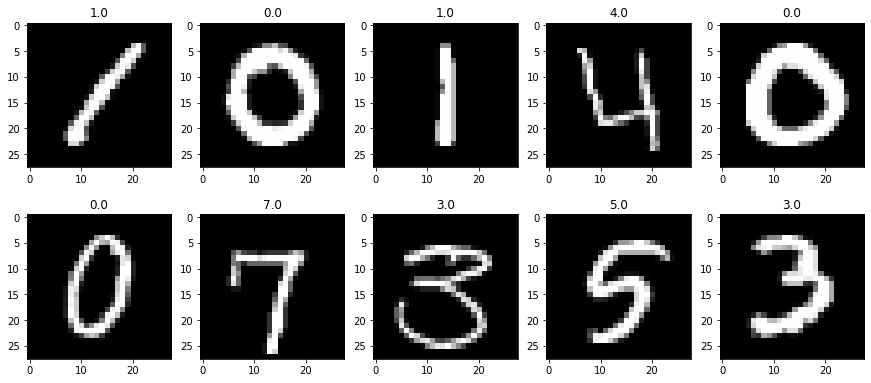

In [4]:
%matplotlib inline
fig = plt.figure(figsize = (15, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(3, 5, i)
    plt.imshow(img, cmap = 'gray')
    subplot.set_title('%s' % train_label[i - 1])

### Calculate the X and Y components of the gradient using the Sobel operator ###

In [5]:
train_sobel_x = np.zeros_like(train_img) # Return an array of zeros
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx = 1, dy = 0, ksize = 3) # 2D array
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx = 0, dy = 1, ksize = 3)

In [6]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx = 1, dy = 0, ksize = 3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx = 0, dy = 1, ksize = 3)

### Calculate the angle and length of the gradient vector ###

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y) # Vector length and angle

In [8]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

### Calculate histograms of gradients ###

In [9]:
# Histograms are calculated taking into account the length of the gradient vector
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins = 16,
                                 range = (0., 2. * np.pi),
                                 weights = train_g[i])
    train_hist[i] = hist

In [10]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins = 16,
                                 range = (0., 2. * np.pi),
                                 weights = test_g[i])
    test_hist[i] = hist

### Normalize the histogram vector ###

In [11]:
# L2 norm is used
train_hist = train_hist / np.linalg.norm(train_hist, axis = 1)[:, None]

In [12]:
test_hist = test_hist / np.linalg.norm(test_hist, axis = 1)[:, None]

### Splitting the sample into training and validation ###

In [13]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size = 0.2,
    random_state = 42)

### Building a network for training on histograms ###

In [14]:
model = keras.models.Sequential() # create 3 layers
model.add(keras.layers.Dense(1000, input_dim = x_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(500, activation = 'sigmoid'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

model.fit(x_train, 
          y_train_labels, 
          batch_size = 300, 
          epochs = 100, 
          shuffle = True, 
          validation_data = (x_val, y_val_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              17000     
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 10)                5010      
                                                                 
Total params: 522,510
Trainable params: 522,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
112/112 [==============================] - 3s 19ms/step - loss: 1.6338 - accuracy: 0.4107 - val_loss: 1.3004 - val_accuracy: 0.5352
Epoch 2/100
112/112 [==============================] - 2s 16ms/step - loss: 1.2175 - accuracy: 0.5656 - val_loss: 1.1599 - val_accuracy: 0.5831
Epoch 3/100
112/112 [=====

Epoch 52/100
112/112 [==============================] - 2s 15ms/step - loss: 0.8823 - accuracy: 0.6811 - val_loss: 0.9294 - val_accuracy: 0.6625
Epoch 53/100
112/112 [==============================] - 2s 15ms/step - loss: 0.8779 - accuracy: 0.6823 - val_loss: 0.9187 - val_accuracy: 0.6662
Epoch 54/100
112/112 [==============================] - 2s 16ms/step - loss: 0.8769 - accuracy: 0.6829 - val_loss: 0.9233 - val_accuracy: 0.6692
Epoch 55/100
112/112 [==============================] - 2s 15ms/step - loss: 0.8781 - accuracy: 0.6847 - val_loss: 0.9275 - val_accuracy: 0.6644
Epoch 56/100
112/112 [==============================] - 2s 16ms/step - loss: 0.8755 - accuracy: 0.6843 - val_loss: 0.9255 - val_accuracy: 0.6646
Epoch 57/100
112/112 [==============================] - 2s 15ms/step - loss: 0.8745 - accuracy: 0.6845 - val_loss: 0.9286 - val_accuracy: 0.6625
Epoch 58/100
112/112 [==============================] - 2s 15ms/step - loss: 0.8734 - accuracy: 0.6835 - val_loss: 0.9170 - val_ac

### Train the model on test data ###

In [15]:
pred_test = model.predict(test_hist)

In [16]:
pred_test1 = []
for i in range(len(pred_test)):
    spisok = list(pred_test[i])
    pred_test1.append(spisok.index(max(spisok)))

### Visualize predictions ###

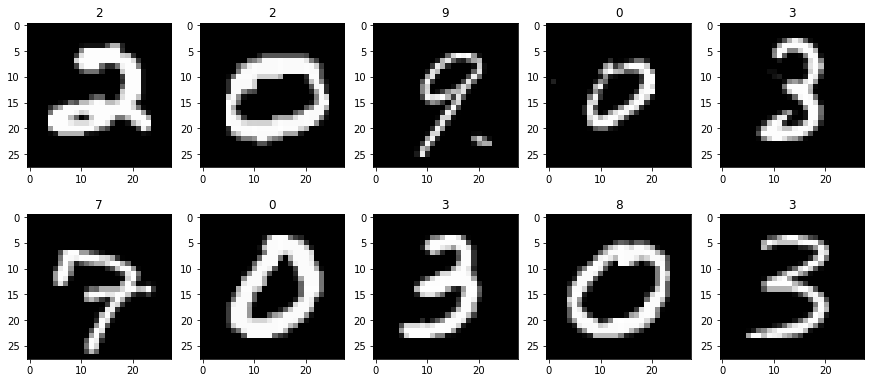

In [17]:
fig = plt.figure(figsize=(15, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(3, 5, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % pred_test1[i - 1])

### Uploading the received data for sending ###

In [18]:
with open('C:/Github/HR/dicision.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test1, 1):
        dst.write('%s,%s\n' % (i, p))